<img src='img/dd.png' style="width:100%"/>

# From raw Yelp reviews to a model of hygiene violations (in 3 easy steps)

We were so excited about our new [civic innovation competition](http://www.drivendata.org/competitions/5/) we couldn't help but get started ourselves!

The goal for this competition is to use data from Yelp restaurant reviews to narrow the search for health code violations in Boston. Competitors will have access to historical hygiene violation records from the City of Boston — a leader in [open government data](https://data.cityofboston.gov) — and [Yelp's consumer reviews](http://www.yelp.com). The challenge: Figure out the words, phrases, ratings, and patterns that predict violations, and help public health inspectors do their job better.

### This notebook contains three sections:

 - [Loading the data](#digging)
 - [Creating some features](#features)
 - [Making a simple model](#model)

We'll get started by loading the python modules in our analysis toolkit.

In [1]:
%matplotlib inline

from IPython import display
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# overwrite ipython defaults
plt.rcParams["figure.facecolor"] = '17344A'
plt.rcParams["axes.facecolor"] = '17344A'
plt.rcParams["figure.figsize"] = (10, 8)

import warnings
warnings.filterwarnings("ignore")

<a id="digging"></a>

# Loading the data

---------------

We'll start by taking a look at the data that is provided--you can find more details if you're curious on the  [problem description page](www.drivendata.org/competitions/5/page/28/) for the competition.

There are two types of data: 
 1. Yelp reviews, business information, users, tips, and check-ins 
 2. Historical hygeine violations as recorded by Boston public health inspectors


In [3]:
# List all the files in the data folder
!ls data

91627a02-ff6a-4fcb-96eb-72c6abca7515.zip
PhaseIISubmissionFormat.csv
SubmissionFormat.csv
business_id.txt
json_to_csv_converter.py
restaurant_ids_to_yelp_ids.csv
train_labels.csv
yelp_academic_dataset_business.csv
yelp_academic_dataset_business.json
yelp_academic_dataset_checkin.csv
yelp_academic_dataset_checkin.json
yelp_academic_dataset_review.csv
yelp_academic_dataset_review.json
yelp_academic_dataset_tip.csv
yelp_academic_dataset_tip.json
yelp_academic_dataset_user.csv
yelp_academic_dataset_user.json
yelp_boston_academic_dataset.tar


In [6]:
# Yelp reviews appear as a single JSON object per line in the file.
# Write the first line of the review file to look at the structure.
! head -n 1 data/yelp_academic_dataset_review.json

{"votes": {"funny": 0, "useful": 0, "cool": 0}, "user_id": "P_Mk0ygOilLJo4_WEvabAA", "review_id": "OeT5kgUOe3vcN7H6ImVmZQ", "stars": 3, "date": "2005-08-26", "text": "This is a pretty typical cafe.  The sandwiches and wraps are good but a little overpriced and the food items are the same.  The chicken caesar salad wrap is my favorite here but everything else is pretty much par for the course.", "type": "review", "business_id": "Jp9svt7sRT4zwdbzQ8KQmw"}


First, we will load in the mappings of `restaurant_id` in the Boston data to `business_id` in the Yelp data. We'll create a dictionary where the keys are Yelp IDs and the values are Boston IDs, and we'll use this later to figure out which restaurant reviews match which hygeine inspections. The dictionary will have the form `business_id: restaurant_id` and look something like:

```
{'W3Lfq_Cmqetp1f1AeupM9w': 'WeEe2m3a',
 'nCGr8lh1FlqzXjtVjUbiNg': 'njoZ5X3r',
 'PvuhIUdbironQ4zNbdU8gA': 'B1oXQmOV',
 'KAb0zhEL3MEhIJ8pLd1OpA': '8gOq01o2',
 ...
}
```

In [5]:
id_map = pd.read_csv("data/restaurant_ids_to_yelp_ids.csv")
id_dict = {}

# each Yelp ID may correspond to up to 4 Boston IDs
for i, row in id_map.iterrows():
    # get the Boston ID
    boston_id = row["restaurant_id"]
    
    # get the non-null Yelp IDs
    non_null_mask = ~pd.isnull(row.ix[1:])
    yelp_ids = row[1:][non_null_mask].values
    
    for yelp_id in yelp_ids:
        id_dict[yelp_id] = boston_id

Next, we'll load in the restaurant reviews. The code below creates a dataframe where each row is a single review from the Yelp dataset. In addition to dropping some of the columns that we won't use in this analysis (though that will probably be relevant to you), we use the ID mapping dictionary we just created to replace the Yelp IDs with the ones in the Boston dataset.

In [9]:
with open("data/yelp_academic_dataset_review.json", 'r') as review_file:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    review_json = '[' + ','.join(review_file.readlines()) + ']'

# read in the json as a DataFrame
reviews = pd.read_json(review_json)

# drop columns that we won't use
reviews.drop(['review_id', 'type', 'user_id', 'votes'], 
             inplace=True, 
             axis=1)

# replace yelp business_id with boston restaurant_id
map_to_boston_ids = lambda yelp_id: id_dict[yelp_id] if yelp_id in id_dict else np.nan
reviews.business_id = reviews.business_id.map(map_to_boston_ids)

# rename first column to restaurant_id so we can join with boston data
reviews.columns = ["restaurant_id", "date", "stars", "text"]    

# drop restaurants not found in boston data
reviews = reviews[pd.notnull(reviews.restaurant_id)]

reviews.head()

,restaurant_id,date,stars,text
0,N6Ok7qOx,2005-08-26,3,This is a pretty typical cafe. The sandwiches...
1,N6Ok7qOx,2005-11-23,3,I agree with other reviewers - this is a prett...
2,N6Ok7qOx,2005-11-23,3,"Decent enough food, but very overpriced. Just ..."
3,N6Ok7qOx,2006-02-24,5,The muffins are great...esp the blueberry! I ...
4,N6Ok7qOx,2007-09-06,3,"Well, well, well, look at me reviewing the res..."


Now that we have our review data from Yelp, we'll load our data for Boston as well. The training data has:

 * `id` - a unique ID per inspection
 * `date` - the date of the inspection
 * `restaurant_id` - a unqiue identifier for the restaurant
 * `*` - the number of minor violations
 * `**` - the number of major violations
 * `***` - the number of severe violations
 
The `SubmissionFormat.csv` file looks the same, but the violation counts are all zeros. We're asking you to predict those violation counts for the inspections in that test set. That is, for each inspection (unqiue date/restaurant combination) how many violations of each level did inspectors uncover?

In [10]:
train_labels = pd.read_csv("data/train_labels.csv", index_col=0)
submission = pd.read_csv("data/SubmissionFormat.csv", index_col=0)
train_labels.head()

,date,restaurant_id,*,**,***
id,,,,,
589,2010-02-02,KAoKWjog,3,0,1
28589,2009-12-10,p038M4om,2,0,0
31170,2008-07-16,B1oXymOV,4,0,0
2600,2015-01-30,m0oWJl3G,1,0,3
1016,2012-03-19,rJoQwlEV,0,0,0


We can plot these violations to see how many occured.

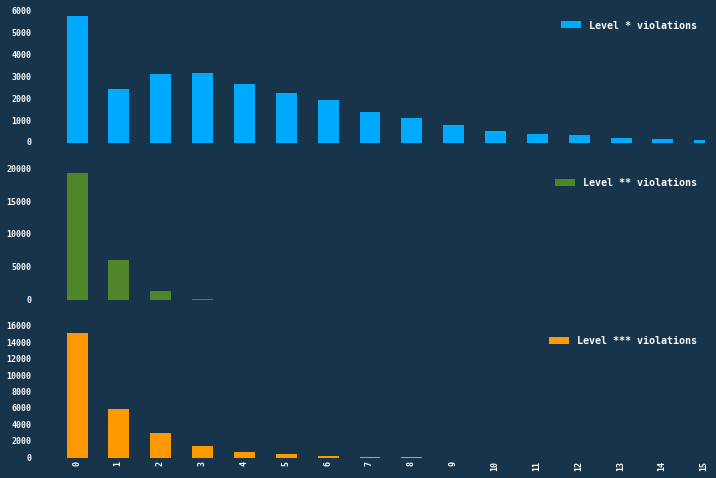

In [11]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    data = train_labels[label]
    vc = data.value_counts()
    idxs = sorted(vc.index)
    vc[idxs].plot(kind="bar",
                  ax=axs[i],
                  xlim=(-1, 15),
                  color=plt.rcParams['axes.color_cycle'][i],
                  grid=False,
                  label='Level {} violations'.format(label))
    axs[i].legend()

<a id="features"></a>

# And now for our feature(s) presentation

---------------

Next, we'll do some text processing to create features. This is the important part of many NLP problems, but we'll just do something simple to get off the ground. [TF-IDF (term frequency, inverse document frequency)](http://en.wikipedia.org/wiki/Tf%E2%80%93idf) weights the occurrence of words based on how often they appear in the overall corpus. That is, words that appear across all the reviews will be less important than words that appear in only a few reviews.

`sklearn` has [very convenient tools to convert text to TF-IDF features](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), so we'll use that for our benchmarking.

The first step is to create the data row-by-row for each output in the training set. For example, take the row:

`20652	2008-05-07	lnORDD3N	9	2	2`

We want to find all of the reviews of restaurant `lnORDD3N` that occurred before the inspection date `2008-05-07`. We'll then look at the occurences of words across all of these reviews, and generate a feature matrix of those words.

In [12]:
# a simple way to create a "document" for an inspection is to
# concatenate all the reviews that happened before the inspection date
def flatten_reviews(label_df, reviews):
    """ label_df: inspection dataframe with date, restaurant_id
        reviews: dataframe of reviews
        
        Returns all of the text of reviews previous to each
        inspection listed in label_df.
    """
    reviews_dictionary = {}
    
    N = len(label_df)

    for i, (pid, row) in enumerate(label_df.iterrows()):
        # we want to only get reviews for this restaurant that ocurred before the inspection
        pre_inspection_mask = (reviews.date < row.date) & (reviews.restaurant_id == row.restaurant_id)
        
        # pre-inspection reviews
        pre_inspection_reviews = reviews[pre_inspection_mask]
        
        # join the text
        all_text = ' '.join(pre_inspection_reviews.text)

        # store in dictionary
        reviews_dictionary[pid] = all_text
        
        if i % 2500 == 0:
            print '{} out of {}'.format(i, N)

    # return series in same order as the original data frame
    return pd.Series(reviews_dictionary)[label_df.index]

<div class="alert alert-warning">
    <p><strong>Note!</strong> The following few cells can take quite a bit of memory. If you find yourself running out of memory, you may want to work on a smaller subset of the data.</p>
    <p>
    ... or you could go buy more memory <img src="http://www.emoji-cheat-sheet.com/graphics/emojis/trollface.png" height="24" width="24" style="display: inline-block;"/></p>
</div>

In [13]:
train_text = flatten_reviews(train_labels, reviews)
train_text.head()

0 out of 27088
2500 out of 27088
5000 out of 27088
7500 out of 27088
10000 out of 27088
12500 out of 27088
15000 out of 27088
17500 out of 27088
20000 out of 27088
22500 out of 27088
25000 out of 27088


id
589      i'm posting this review on behalf of my boyfri...
28589    A great addition to Peabody Square! It is an u...
31170    This is definitely the best place to eat in Bo...
2600     Well, it's nothing spectacular, but if you're ...
1016     The thinking cup has a great atmosphere, I wou...
dtype: object

In [14]:
test_text = flatten_reviews(submission, reviews)
test_text.head()

0 out of 6772
2500 out of 6772
5000 out of 6772


id
14916    I've walked by this place a lot and always won...
29767    You pick up a lunch tray when you walk in and ...
29338    Punjab Palace is the new Allston-area restaura...
7219     Every first year student at Northeastern Unive...
20979    Honestly, subpar.  Same greasy, tasty food as ...
dtype: object

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TfidfVectorizer object with english stop words
# and a maximum of 1500 features (to ensure that we can
# train the model in a reasonable amount of time)
vec = TfidfVectorizer(stop_words='english',
                      max_features=1500)

# create the TfIdf feature matrix from the raw text
train_tfidf = vec.fit_transform(train_text)

In [16]:
# take a quick look at some of the features
pd.DataFrame(data=train_tfidf.todense(), columns=vec.get_feature_names()).iloc[:5, 30:45]

,ago,agree,ahead,air,al,alcohol,allston,alright,amazing,ambiance,ambience,american,annoying,anymore,anyways
0,0.000000,0.000000,0.049236,0.000000,0.00000,0.000000,0,0.000000,0.032329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.011249,0.000000,0.00000,0.000000,0,0.000000,0.014773,0.010161,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.000000,0.012445,0.034242,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.007069,0.003506,0.001920,0.000000,0.00000,0.002052,0,0.003661,0.016389,0.005203,0.000000,0.003347,0.001929,0.003877,0.000000
4,0.002872,0.000000,0.001950,0.014178,0.00252,0.000000,0,0.000000,0.042260,0.019379,0.008716,0.001700,0.005879,0.001969,0.002036


<a id="model"></a>

# Our first model

---------------

Now it's time to make some predictions. We'll start off with a straightforward model: [ordinary least squares regression](http://en.wikipedia.org/wiki/Ordinary_least_squares). OLS can be written as:

$$
y_i = x_i ^T \beta + \varepsilon_i
$$

In our model, we can think of $i$ as a single inspection of a restaurant. $y_i$ is the number of violations the inspectors found during inspection $i$. We'll create three separate OLS models, one for each violation level [\*, \*\*, \*\*\*]. $x_i$ is the corresponding row in the TF-IDF matrix that we created above. 

$\beta$ is the vector of coefficients that correspond to each word in the TF-IDF matrix. For example, the coefficient for the word "annoying" above, $\beta_\textrm{annoying}$, may be large relative to the other coefficients. Since all of our $x$ values are greater than zero, we can see from the linear regression equation that a larger $\beta_\textrm{annoying}$ means we will expect to see more violations ($y_i$) when the word "annoying" appears in a review. 

In [17]:
from sklearn import linear_model

# get just the targets from the training labels
train_targets = train_labels[['*', '**', '***']].astype(np.float64)

# create a Linear regresion object
ols = linear_model.LinearRegression()

# fit that object on the training TfIdf matrix and target variables
ols.fit(train_tfidf, train_targets)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

That output is not very satisfying, is it? For kicks, let's see what the smallest and largest coefficients are. Remember, these coefficients determine the effect size for seeing a word a certain number of times. In general, the larger the coefficient, the more violations we might expect to see given an occurrence of that word.

**Note:** this is not generally true of regression coefficients, but is here because we are looking at variables that are all constrained to the same scale.

In [18]:
# get the names of the features
feature_names = np.array(vec.get_feature_names())

def get_top_features(features, model, level, limit, bottom=False):
    """ Get the top (most likely to see violations) and bottom (least
        likely to see violations) features for a given model.
        
        :param features: an array of the feature names
        :param model: a fitted linear regression model
        :param level: 0, 1, 2 for *, **, *** violation levels
        :param limit: how many features to return
        :param worst: if we want the bottom features rather than the top 
    """
    # sort order for the coefficients
    sorted_coeffs = np.argsort(model.coef_[i])
    
    if bottom:
        # get the features at the end of the sorted list
        return features[sorted_coeffs[-1 * limit:]]
    else:
        # get the features at the beginning of the sorted list
        return features[sorted_coeffs[:limit]]
    
# get the features that indicate we are most and least likely to see violations
worst_feature_sets = [get_top_features(feature_names, ols, i, 100) for i in range(3)]
best_feature_sets = [get_top_features(feature_names, ols, i, 100, bottom=True) for i in range(3)]

# reduce the independent feature sets to just the ones
# that we see in common across the per-level models (*, **, ***)
worst = reduce(np.intersect1d, best_feature_sets)
best = reduce(np.intersect1d, worst_feature_sets)

# display as a pretty table
html_fmt = "<table><th>More Violations</th><th>Fewer Violations</th><tbody>{}</tbody></table>"
table_rows = ["<tr><td>{}</td><td>{}</td></tr>".format(w, b) for w, b in zip(worst, best)]
table_body = "\n".join(table_rows)
display.HTML(html_fmt.format(table_body))

butter,basement
diners,checking
peppers,leaves
pitcher,lighting
received,number
recommendation,parties
reminded,paying
rushed,pleasant
strange,spectacular
tempura,split


# Write the submission file for DrivenData

Finally, we'll write out our predictions so we can submit them to the [Keeping it Fresh competition](http://www.drivendata.org/competitions/5/).

In [19]:
# create the same tfidf matrix for the test set
# so we can make predictions based on the same features
test_tfidf = vec.transform(test_text)

# predict the counts for the test set
predictions = ols.predict(test_tfidf)

# clip the predictions so they are all greater than or equal to zero
# since we can't have negative counts of violations
predictions = np.clip(predictions, 0, np.inf)

In [20]:
# write the submission file
new_submission = submission.copy()
new_submission.iloc[:, -3:] = predictions.astype(int)
new_submission.to_csv("LinearRegression.csv")
new_submission.head()

,date,restaurant_id,*,**,***
id,,,,,
14916,2014-12-17,nkOvZOBW,5,0,0
29767,2013-12-30,WwOaAnOB,4,0,1
29338,2011-04-08,we39kvOk,2,0,0
7219,2013-12-30,dj3d5Xo9,2,0,0
20979,2008-03-31,XJ3rBW3R,4,0,1


![](img/score3.png)

<p><div class="well" align="center">
<a href="http://www.drivendata.org"><img src='img/dd.png' style="width:100%"/></a>
<h1>[www.drivendata.org](http://www.drivendata.org)
</h1></div>

* Check out our <strong>[forum](http://community.drivendata.org/)</strong>
* Or, give us a shout out on twitter: **[@drivendataorg](https://twitter.com/drivendataorg)**
